# Modelling zircon saturation as a function of melt water content

This Jupyter notebook is a minimum working example of the modelling used in the paper: A zircon case for super-wet arc magmas by Nathwani et al. (submitted)

In [1]:
# Import packages to be used
from thermoengine import equilibrate, core, model, phases
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
# !pip install periodictable
import periodictable as pt
from functions import calc_opt_bas
from functions import fo2buffer
from functions import calc_Fe2O3_FeO
from functions import BA_rutile_solubility
import scipy as scipy
from matplotlib.lines import Line2D

%matplotlib inline

# Instantiate MELTS model
melts = equilibrate.MELTSmodel('1.1.0')


In [2]:
def calc_xH2O(df):
    # Calculate mole fraction H2O in the melt
    df['FeO'] = df['FeO'] + df['Fe2O3']/1.1111
    
    SiO2_mol = df['SiO2']/pt.formula("SiO2").mass
    K2O_mol = df['K2O']/pt.formula("K2O").mass
    CaO_mol = df['CaO']/pt.formula("CaO").mass
    MgO_mol = df['MgO']/pt.formula("MgO").mass
    MnO_mol = df['MnO']/pt.formula("MnO").mass
    FeO_mol = df['FeO']/pt.formula("FeO").mass
    Al2O3_mol = df['Al2O3']/pt.formula("Al2O3").mass
    H2O_mol = df['H2O']/pt.formula("H2O").mass
    
    total_mol = (SiO2_mol+K2O_mol+CaO_mol+MgO_mol+
                 MnO_mol+FeO_mol+Al2O3_mol+H2O_mol)
    
    xH2O = H2O_mol/total_mol
    
    return(xH2O)

def calc_zrsat(T, P, xH2O, opt_bas):
    # Crisp and Berry 2022 zircon saturation model
    T = T + 273.15
    P = P/1000
    logzr = (0.96-(5790/T)-(1.28*P)+(12.39*opt_bas)+
             (0.83*xH2O)+(2.06*P*opt_bas)
            )
    zrsat = 10**(logzr)
    return(logzr)

def calc_Ti_crisp(T, P, aTiO2, aSiO2):
    # Crisp and Berry 2023 Ti in zircon thermometer
    T = T + 273.15
    P = P/1000 # Convert to GPa
    f = 1 / (1+10**-(-0.77*P+3.37))
    logTif = 5.84 - (4800/T) - 0.12*P - 0.0056*P**3 - np.log10(aSiO2)*f + np.log10(aTiO2)
    Ti = (10**logTif)/f
    return(Ti)

def T_calc(Ti_zrc, P, aTiO2, aSiO2):
    T_K = (-4800+(0.4748*(P-1000)))/(np.log10(Ti_zrc)-5.5711-np.log10(aTiO2)+np.log10(aSiO2))
    T_C = T_K - 273.15
    return(T_C)


# Parameterise the mineral-melt partition cofficients for Zr
D_Zr = pd.read_csv('Zr_D_Values.csv')
groups = [D_Zr.groupby('Mineral').get_group(x) for x in D_Zr.groupby('Mineral').groups]
DZr_params = []
minerals = []

for n,i in enumerate(groups):
    m = np.polyfit(i['Temperature'], i['DZr'],3)
    DZr_params.append(m)
    minerals.append(i['Mineral'].iloc[0])
    Ds = np.poly1d(m)(np.linspace(700,1200,50))

def calc_D_Zr(t, SiO2):
    R =  0.008314 
    D_amph = np.poly1d(DZr_params[0])(t)
    D_biotite = np.poly1d(DZr_params[1])(t)
    D_cpx = np.poly1d(DZr_params[2])(t)
    D_ilm = np.poly1d(DZr_params[3])(t)
    D_opx = D_cpx*(1/3)
    D_spl = D_ilm*(1/3)
    D_plag = np.exp((2.2602 * SiO2 - 187.27)/(R*(t+273.15)))
    Zr_Ds = [D_amph, D_biotite, D_cpx, D_ilm, D_opx, D_spl, D_plag]
    minerals = ['Amphibole', 'Biotite', 'Clinopyroxene', 'Ilmenite', 'Orthopyroxene', 'Spinel', 'Plagioclase']
    Zr_Ds = pd.DataFrame({'Mineral':minerals, 'DZr': Zr_Ds})
    Zr_Ds['DZr'] = Zr_Ds['DZr'].clip(lower=0)
    return(Zr_Ds)

# An example of the output of the DZr parameterisation
print(calc_D_Zr(1000,60))

         Mineral       DZr
0      Amphibole  0.346010
1        Biotite  0.190164
2  Clinopyroxene  0.060881
3       Ilmenite  0.452447
4  Orthopyroxene  0.020294
5         Spinel  0.150816
6    Plagioclase  0.007595


## Generate T-X curves at different initial melt water contents

Use thermoengine to calculate different temperature-melt fraction curves and extract relevant information from MELTS for later calculation of the mass fraction of zircon crystallised

In [3]:
p_start = 400 # Starting P in MPa
water_contents = np.arange(2,8+1) # Water contents to test
start_T = 1100 # Starting T in C
end_T = 680 # Final T
t_increment_of_steps = -10 # Increment of T
number_of_steps = int((start_T-end_T)/abs(t_increment_of_steps))
p_increment_of_steps = 0.0
R = 8.3145 # Gas constant

frac_coeff = melts.get_dictionary_of_default_fractionation_coefficients()

# # Marxer Ulmer Adamello starting composition
comp = {'SiO2':  60.81, 'TiO2':   0.64, 'Al2O3': 17.95, 'Fe2O3':  0,
          'Cr2O3':  0.0, 
          'FeO':    5.6, 
          'MnO':    0.13,
          'MgO':    3.03, 
          'NiO':    0.0, 
          'CoO':    0.0,
          'CaO':    7.26, 
          'Na2O':   2.89, 
          'K2O':    1.69, 
          'P2O5':   0.0, 
          'H2O':    0,
          'CO2':    0.00}

# Instantiate arrays
T_all = []
F_all = []
comps_all = []
aTiO2_all = []
aSiO2_all = []
enthalpies_all = []
bulk_DZrs_all = []
water_sat_all = []
for i in water_contents:
    
    # Suppress phases that are unexpected
    melts.set_phase_inclusion_status({'Aegirine':False, \
                                  'Aenigmatite':False, 'Akermanite':False, 'Andalusite':False, \
                                  'Anthophyllite':False, 'Chromite':False, \
                                  'Coesite':False, 'Corundum':False, 'Cristobalite':False, 'Cummingtonite':False, \
                                  'Garnet':False,'Gehlenite':False, 'Hematite':False, 'Kalsilite':False, \
                                  'Kalsilite ss':False, 'Kyanite':False, 'Leucite':False, 'Lime':False, \
                                  'Liquid Alloy':False, 'Melilite':False,  \
                                  'Nepheline':False, 'Nepheline ss':False, 'Panunzite':False, \
                                  'Periclase':False, 'Perovskite':False, 'Phlogopite':True, \
                                  'Sillimanite':False, 'Solid Alloy':False, \
                                  'Tridymite':False, 'Whitlockite':False})
    p = p_start
    xPlot = np.zeros(number_of_steps+1)
    yPlot = np.zeros(number_of_steps+1)
    run_comp = comp
    run_comp = calc_Fe2O3_FeO(comp, start_T, p, 'NNO', 0) # Calculate Fe valence state
    total = sum(run_comp.values())+i
    run_comp = {k: 100 * v / total for k, v in run_comp.items()} # Normalise to hydrous %
    run_comp['H2O'] = i
    melts.set_bulk_composition(run_comp) # Instantiate MELTS with composition
    output = melts.equilibrate_tp(start_T, p, initialize=True) # First step
    (status, t, p, xmlout) = output[0]
    xPlot[0] = start_T
    yPlot[0] = melts.get_property_of_phase(xmlout, 'Liquid')
    # Instantiate arrays
    comps = []
    aTiO2_list = []
    aSiO2_list = []
    bulk_DZrs = []
    water_sat = []
    oxides = melts.get_composition_of_phase(xmlout, 'Liquid') # Get liquid composition
    comps.append(oxides)

     # Calculate bulk D Zr partition coefficient
    phases = melts.get_list_of_phases_in_assemblage(xmlout)
    masses = []
    for phase in phases:
            masses.append(melts.get_mass_of_phase(xmlout, phase))
    df = pd.DataFrame({'Phases':phases,'Mass':masses})
    df = df.drop(df[df.Phases == 'Liquid'].index)
    df['Mass'] = df['Mass']/df['Mass'].sum()
    df = df.replace({'Augite':'Clinopyroxene', 'Ilmenite ss':'Ilmenite','Titanaugite':'Clinopyroxene'}) # Simplify minerals
    df['Mass'] = df.groupby(['Phases'])['Mass'].transform('sum') # Identify and drop duplicates
    df = df.drop_duplicates(subset=['Phases'])
    D_Zr = calc_D_Zr(t, oxides['SiO2'])
    df = df.set_index("Phases")
    df2 = D_Zr.set_index("Mineral")["DZr"]
    res = df.mul(df2, axis=0).combine_first(df)
    bulkDZr = res['Mass'].sum()
    bulk_DZrs.append(bulkDZr) # Append DZr
    
    # Calculate aTiO2 and aSiO2 outputted from MELTS (NB the former is not used further, but just as a comparison)
    dict = melts.get_dictionary_of_affinities(xmlout, sort=True)
    if 'Rutile' in dict: # Calculate TiO2 activity IF rutile is an unstable phase
        aTiO2 = np.exp(-dict['Rutile'][0]/(R*(start_T+273.15))) 
    else: # Else if rutile IS stable aTiO2 = 1
        aTiO2 = 1
    aTiO2_list.append(aTiO2)
    if 'Quartz' in dict: # Same for quartz and aSiO2
        aSiO2 = np.exp(-dict['Quartz'][0]/(R*(start_T+273.15))) 
    else:
        aSiO2 = 1
    aSiO2_list.append(aSiO2)
    # Now, loop over each T increment along the liquid line of descent
    for i in range (1, number_of_steps+1):
        frac_output = melts.fractionate_phases(xmlout, frac_coeff)
        output = melts.equilibrate_tp(t+t_increment_of_steps, p+p_increment_of_steps, initialize = False) # Next step
        (status, t, p, xmlout) = output[0] # Save output
        # Calculate bulk D Zr partition coefficient
        phases = melts.get_list_of_phases_in_assemblage(xmlout)
        masses = []
        for phase in phases:
                masses.append(melts.get_mass_of_phase(xmlout, phase))
        df = pd.DataFrame({'Phases':phases,'Mass':masses})
        df = df.drop(df[df.Phases == 'Liquid'].index)
        df['Mass'] = df['Mass']/df['Mass'].sum()
        df = df.replace({'Augite':'Clinopyroxene', 'Ilmenite ss':'Ilmenite','Titanaugite':'Clinopyroxene'})
        df['Mass'] = df.groupby(['Phases'])['Mass'].transform('sum') # Identify and drop duplicates
        df = df.drop_duplicates(subset=['Phases'])
        D_Zr = calc_D_Zr(t, oxides['SiO2'])
        df = df.set_index("Phases")
        df2 = D_Zr.set_index("Mineral")["DZr"]
        res = df.mul(df2, axis=0).combine_first(df)
        bulkDZr = res['Mass'].sum()
        bulk_DZrs.append(bulkDZr)
        oxides = melts.get_composition_of_phase(xmlout, 'Liquid')
        mass = melts.get_property_of_phase(xmlout,'System', 'Mass')
        comps.append(oxides)
        melts.get_property_of_phase(xmlout, 'Fluid')
        water_sat.append(melts.get_thermo_properties_of_phase_components(xmlout,phase_name = 'Fluid', mode = 'activity'))
        xPlot[i] = t
        yPlot[i] = melts.get_property_of_phase(xmlout, 'Liquid')
        dict = melts.get_dictionary_of_affinities(xmlout, sort=True)
        if 'Quartz' in dict:
            aSiO2 = np.exp(-dict['Quartz'][0]/(R*(t+273.15)))
        else:
            aSiO2 = 1
        if 'Rutile' in dict:
            aTiO2 = np.exp(-dict['Rutile'][0]/(R*(t+273.15)))
        else:
            aTiO2 = 1
        aTiO2_list.append(aTiO2)
        aSiO2_list.append(aSiO2)
    comps_all.append(comps)    
    T_all.append(xPlot)
    F_all.append(yPlot)
    aTiO2_all.append(aTiO2_list)
    aSiO2_all.append(aSiO2_list)
    bulk_DZrs_all.append(bulk_DZrs)
    water_sat_all.append(water_sat)

Zeroed: FeO
Zeroed: TiO2
Zeroed: FeO
Zeroed: FeO
Zeroed: FeO
Zeroed: FeO
Zeroed: FeO
Zeroed: FeO
Zeroed: FeO
Zeroed: FeO
Zeroed: FeO


## Calculate zircon saturation in different melt water content models and the total mass fraction of zircon saturated at a given T increment

<>:17: DeprecationWarning: invalid escape sequence \m
<>:17: DeprecationWarning: invalid escape sequence \m
<>:17: DeprecationWarning: invalid escape sequence \m
<>:18: DeprecationWarning: invalid escape sequence \m
<>:18: DeprecationWarning: invalid escape sequence \m
<>:18: DeprecationWarning: invalid escape sequence \m
<>:19: DeprecationWarning: invalid escape sequence \m
<>:17: DeprecationWarning: invalid escape sequence \m
<>:17: DeprecationWarning: invalid escape sequence \m
<>:17: DeprecationWarning: invalid escape sequence \m
<>:18: DeprecationWarning: invalid escape sequence \m
<>:18: DeprecationWarning: invalid escape sequence \m
<>:18: DeprecationWarning: invalid escape sequence \m
<>:19: DeprecationWarning: invalid escape sequence \m
/tmp/ipykernel_224/3781271388.py:17: DeprecationWarning: invalid escape sequence \m
  axs[0,0].legend(custom_lines, ['8 wt.% $\mathregular{H_2}$O', '7 wt.% $\mathregular{H_2}$O', '6 wt.% $\mathregular{H_2}$O',
/tmp/ipykernel_224/3781271388.py:1

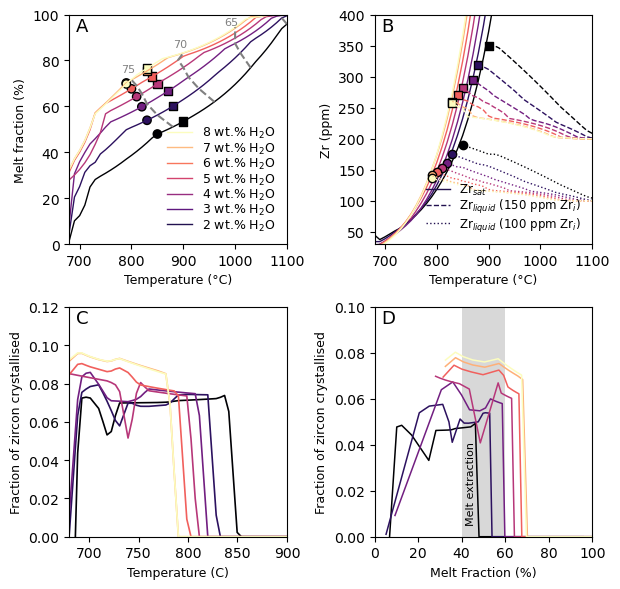

In [5]:
fig, axs = plt.subplots(2,2, figsize = (6.3,6))

water_contents = np.arange(2,8+1) # Water contents to test

# Set colours and lines for plotting H2O contents
norm = mpl.colors.Normalize(vmin=water_contents.min(), vmax=water_contents.max())
cmap = mpl.cm.magma
custom_lines = [Line2D([0], [0], color=cmap(1/len(water_contents)*7), lw=1),
                Line2D([0], [0], color=cmap(1/len(water_contents)*6), lw=1),
                Line2D([0], [0], color=cmap(1/len(water_contents)*5), lw=1),
               Line2D([0], [0], color=cmap(1/len(water_contents)*4), lw=1),
               Line2D([0], [0], color=cmap(1/len(water_contents)*3), lw=1),
               Line2D([0], [0], color=cmap(1/len(water_contents)*2), lw=1),
               Line2D([0], [0], color=cmap(1/len(water_contents)*1), lw=1)]

# Make legend for different H2O
axs[0,0].legend(custom_lines, ['8 wt.% $\mathregular{H_2}$O', '7 wt.% $\mathregular{H_2}$O', '6 wt.% $\mathregular{H_2}$O',
                        '5 wt.% $\mathregular{H_2}$O', '4 wt.% $\mathregular{H_2}$O', '3 wt.% $\mathregular{H_2}$O',
                        '2 wt.% $\mathregular{H_2}$O'], prop={'size': 9},labelspacing=0.03, frameon=False)

# Define more custom lines
custom_lines = [Line2D([0], [0], label='Zr$_{sat}$', lw = 1, color = cmap(1/len(water_contents)*1)),
                Line2D([0], [0], label='Zr$_{sat}$', lw = 1, linestyle = 'dashed', color = cmap(1/len(water_contents)*1)),
                Line2D([0], [0], label='Zr$_{sat}$', lw = 1, linestyle = 'dotted', color = cmap(1/len(water_contents)*1))]

# Make second legend for Zr starting composition
axs[0,1].legend(custom_lines, ['Zr$_{sat}$','Zr$_{liquid}$ (150 ppm Zr${_i}$)', 'Zr$_{liquid}$ (100 ppm Zr${_i}$)'], prop={'size': 8.5},labelspacing=0.03, loc = 4, frameon=False)

# Instantiate some arrays
idx_SiO2_60 = []
idx_SiO2_65 = []
idx_SiO2_70 = []
idx_SiO2_75 = []

start_Zr_high = 200 # ppm
start_Zr_low = 100 # ppm

zrc_sat_1 = []
zrc_sat_2 = []
zrc_sat_3 = []

cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.magma)
cmap.set_array([])
n = 0
for i,j,k, aTiO2, aSiO2, bulkD_Zr in zip(comps_all, T_all, F_all, aTiO2_all, aSiO2_all, bulk_DZrs_all):
    i = pd.DataFrame.from_dict(i) # convert for df
    i = i.clip(lower=0)
    i = i.fillna(0) # fill nan values with zeros
    xH2O = calc_xH2O(i) # calc mol frac H2O
    totals = i['SiO2'] + i['TiO2'] + i['Al2O3'] +  i['Fe2O3'] +  i['FeO'] +  i['MnO'] + i['MgO'] +  i['CaO'] +  i['Na2O'] + i['K2O']
    for col in i.iloc[:,:-1]:
        i[col] = 100*(i[col]/totals)
    i['opt bas'] = calc_opt_bas(i) # calc opt basicity
    
    # There is a problem in the 2wt% run that a suddenly  a large amount of cpx appears in 1 increment causing bulkDZr to increase by 500%, I have added brief cheat code to stop this happening for now
    if n == 0:
        bulkD_Zr[26:] = [bulkD_Zr[25]]* len(bulkD_Zr[26:])
    
    
    # Fit optical basicity curve to only above 800C to avoid strange behaviour with MELTS at lower temperature
    m = np.polyfit(j[0:np.argmax(j == 850)], calc_opt_bas(pd.DataFrame.from_dict(i))[0:np.argmax(j == 850)], 2)
    corrected = np.poly1d(m)(j)
    i['opt bas'] = corrected
    i['xH2O'] = xH2O
    i['P'] = [p]*len(i)
    i['Zr sat'] = calc_zrsat(pd.Series(j), i['P'], i['xH2O'], i['opt bas'])
    bulkD_Zr = np.array(bulkD_Zr)
    # Calculate melt 
    i['Zr conc_1'] = start_Zr_high * (k/100)**(bulkD_Zr-1) 
    i['Zr conc_2'] = start_Zr_low * (k/100)**(bulkD_Zr-1)
    i['SiO2 (anhydrous)'] = i['SiO2']/totals *100
    
    
    idx = np.argwhere(np.diff(np.sign(i['Zr conc_1'] - 10**i['Zr sat']))).flatten()[0] # Find index in which zircon saturation occurs
    
    # Plot
    axs[0,1].plot(j, 10**i['Zr sat'], zorder = 0, c = cmap.to_rgba(water_contents[n]), linewidth = 1)
    axs[0,1].plot(j[0:int(idx)+1],i['Zr conc_1'][0:int(idx)+1], color = cmap.to_rgba(water_contents[n]), linestyle = 'dashed', linewidth = 1)
    axs[0,1].scatter(j[idx], i['Zr conc_1'][idx], marker = 's', color = cmap.to_rgba(water_contents[n]), edgecolor = 'black')
    zrc_sat_1.append([j[idx],k[idx],aTiO2[idx],aSiO2[idx]])
    idx = np.argwhere(np.diff(np.sign(i['Zr conc_2'] - 10**i['Zr sat']))).flatten()[0] # Find index in which zircon saturation occurs
    axs[0,1].plot(j[0:int(idx)+1],i['Zr conc_2'][0:int(idx)+1], color = cmap.to_rgba(water_contents[n]), linestyle = 'dotted', linewidth = 1)
    bulkD_Zr[0:int(idx)+1][-3:-1] = bulkD_Zr[0:int(idx)+1][-5:-3]
    axs[0,1].scatter(j[idx], i['Zr conc_2'][idx], marker = 'o', color = cmap.to_rgba(water_contents[n]), edgecolor = 'black')
    zrc_sat_2.append([j[idx],k[idx],aTiO2[idx],aSiO2[idx]])
    
    #Calculate the putative excess Zr in the melt
    zr_star = np.zeros(len(i))
    zr_star2 = np.zeros(len(i))
    n2 = 0
    zr_star = []
    for a in (i['Zr conc_2'] > 10**i['Zr sat']):
        if a == True:
            zr_star.append(((i['Zr sat'][n2-1]-i['Zr sat'][n2])))
        if a == False:
            zr_star.append(0)
        n2 = n2 + 1    
    fun = scipy.interpolate.interp1d(x=j, y=zr_star/np.sum(zr_star), kind=1) # Interpolate excess Zr
    ts = np.linspace(1100,680,100)
    y2 = fun(ts)
    axs[1,0].plot(ts, y2,color = cmap.to_rgba(water_contents[n]), linewidth = 1.2)
    axs[1,0].set_xlim([950,680])
    
    fun = scipy.interpolate.interp1d(x=k, y=zr_star/np.sum(zr_star), kind=1)
    axs[1,1].plot(k, zr_star,color = cmap.to_rgba(water_contents[n]), linewidth = 1.1)
    
    zr_star = []
    n2 = 0
            
    for a in np.arange(len(i)):
        if a == idx:
            zr_star2[a] = i.iloc[a]['Zr conc_2'] - 10**i.iloc[a]['Zr sat']
        elif a > idx:
            zr_star2[a] = i.iloc[a]['Zr conc_2'] - i.iloc[a-1]['Zr conc_2']
        elif a < idx:
            zr_star2[a] = 0
    
    # Calculate SiO2 contours for each run
    idx_SiO2_60.append(np.argmax(i['SiO2 (anhydrous)'] > 60))
    idx_SiO2_65.append(np.argmax(i['SiO2 (anhydrous)'] > 65))
    idx_SiO2_70.append(np.argmax(i['SiO2 (anhydrous)'] > 70))
    idx_SiO2_75.append(np.argmax(i['SiO2 (anhydrous)'] > 75))
    
    n = n + 1

# Add axes labels
axs[0,1].set_ylim([30,400])
axs[0,1].set_xlim([680,1100])
axs[0,1].set_ylabel('Zr (ppm)', fontsize = 9)
axs[0,1].set_xlabel('Temperature (°C)', fontsize = 9)

# Loop for plotting
i = 0
for x,y in zip(T_all, F_all):
    norm = mpl.colors.Normalize(vmin=water_contents.min(), vmax=water_contents.max())
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.magma)
    cmap.set_array([])
    axs[0,0].plot(x,y, c = cmap.to_rgba(water_contents[i]), lw = 1)
    i = i + 1

r, _ = np.array(T_all).shape  # get how many rows to use in np.arange(r)

axs[0,0].plot(np.array(T_all)[np.arange(r), np.array(idx_SiO2_60)], np.array(F_all)[np.arange(r), np.array(idx_SiO2_60)],
             color = 'gray', linestyle = 'dashed')
axs[0,0].plot(np.array(T_all)[np.arange(r), np.array(idx_SiO2_65)], np.array(F_all)[np.arange(r), np.array(idx_SiO2_65)],
             color = 'gray', linestyle = 'dashed')
axs[0,0].plot(np.array(T_all)[np.arange(r), np.array(idx_SiO2_70)], np.array(F_all)[np.arange(r), np.array(idx_SiO2_70)],
             color = 'gray', linestyle = 'dashed')
axs[0,0].plot(np.array(T_all)[np.arange(r), np.array(idx_SiO2_75)], np.array(F_all)[np.arange(r), np.array(idx_SiO2_75)],
             color = 'gray', linestyle = 'dashed')
     
    
# plt.text(950, 70, '2 wt.% $\mathregular{H_2}$O', fontsize = 'small', rotation = 50)

# plt.text(900, 70, '3 wt.% $\mathregular{H_2}$O', fontsize = 'small',rotation = 50)


axs[0,0].set_xlim([680,1100])
axs[0,0].set_ylim([0,100])
axs[0,0].set_ylabel('Melt fraction (%)', fontsize = 9)
axs[0,0].set_xlabel('Temperature (°C)', fontsize = 9)
axs[0,0].set_xlabel('Temperature (°C)', fontsize = 9)
# fig.colorbar(cmap, ticks=water_contents)

axs[0,0].scatter(np.array(zrc_sat_1)[:,0], np.array(zrc_sat_1)[:,1],marker = 's', color = cmap.to_rgba(water_contents), edgecolor = 'black')
axs[0,0].scatter(np.array(zrc_sat_2)[:,0], np.array(zrc_sat_2)[:,1],marker = 'o', color = cmap.to_rgba(water_contents), edgecolor = 'black')

axs[1,0].set_ylim([0,0.12])
axs[1,0].set_xlim([680,900])

axs[1,0].set_xlabel('Temperature (C)', fontsize = 9)
axs[1,0].set_ylabel('Fraction of zircon crystallised', fontsize = 9)

axs[1,1].set_ylim([0,0.10])
axs[1,1].set_xlim([0,100])

axs[1,1].set_xlabel('Melt Fraction (%)', fontsize = 9)
axs[1,1].set_ylabel('Fraction of zircon crystallised', fontsize = 9)

axs[1,1].axvspan(40, 60, color='gray', alpha=0.3, lw=0) # Optimal melt extraction window

axs[1,1].annotate('Melt extraction', xy = (42,0.006),
            horizontalalignment='left', fontsize=8, rotation = 90)


captions = ['A','B','C','D']
for n, ax in enumerate(axs.flatten()):
    ax.annotate(captions[n], xycoords = 'axes fraction', xy = (0.03,0.93), fontsize = 13)

axs[0,0].text(780,75, ('75'), color = 'gray', fontsize = 8)
axs[0,0].text(880,86, ('70'), color = 'gray', fontsize = 8)
axs[0,0].text(980,95.5, ('65'), color = 'gray', fontsize = 8)

plt.rcParams['svg.fonttype'] = 'none'
plt.tight_layout()
plt.savefig('Model.svg', dpi = 1200)
plt.show()
    

## Run MELTS models at different pressures for comparison
Note - this can crash at higher pressures.

In [3]:
pressures = [200, 400, 600] # Pressures in MPa to test

T_all_P = []
F_all_P = []
aTiO2_all_P = []
aSiO2_all_P = []
comps_all_P = []
bulk_DZrs_all_P = []

water_contents = np.arange(2,8+1) # Water contents to test
start_T = 1100 # Starting T in C
end_T = 680 # Final T
t_increment_of_steps = -10 # Increment of T
number_of_steps = int((start_T-end_T)/abs(t_increment_of_steps))
p_increment_of_steps = 0.0
R = 8.3145 # Gas constant

frac_coeff = melts.get_dictionary_of_default_fractionation_coefficients()

# Marxer Ulmer
comp = {'SiO2':  60.81, 
        'TiO2':   0.64, 
        'Al2O3': 17.95, 
        'Fe2O3':  0,
          'Cr2O3':  0.0, 
          'FeO':    5.6, 
          'MnO':    0.13,
          'MgO':    3.03, 
          'NiO':    0.0, 
          'CoO':    0.0,
          'CaO':    7.26, 
          'Na2O':   2.89, 
          'K2O':    1.69, 
          'P2O5':   0.0, 
          'H2O':    0,
          'CO2':    0.00}

for p in pressures:
    melts = equilibrate.MELTSmodel('1.1.0')
    T_all = []
    F_all = []
    comps_all = []
    aTiO2_all = []
    aSiO2_all = []
    bulk_DZrs_all = []
    for i in water_contents:
        
        # Suppress phases that are unexpected
        melts.set_phase_inclusion_status({'Aegirine':False, \
                              'Aenigmatite':False, 'Akermanite':False, 'Andalusite':False, \
                              'Anthophyllite':False, 'Chromite':False, \
                              'Coesite':False, 'Corundum':False, 'Cristobalite':False, 'Cummingtonite':False, \
                              'Garnet':False,'Gehlenite':False, 'Hematite':False, 'Kalsilite':False, \
                              'Kalsilite ss':False, 'Kyanite':False, 'Leucite':False, 'Lime':False, \
                              'Liquid Alloy':False, 'Melilite':False,  \
                              'Nepheline':False, 'Nepheline ss':False, 'Panunzite':False, \
                              'Periclase':False, 'Perovskite':False, 'Phlogopite':True, \
                              'Sillimanite':False, 'Solid Alloy':False, \
                              'Tridymite':False, 'Whitlockite':False})

        xPlot = np.zeros(number_of_steps+1)
        yPlot = np.zeros(number_of_steps+1)
        run_comp = comp
        run_comp = calc_Fe2O3_FeO(comp, start_T, p, 'NNO', 0) # Calculate Fe valence state
        total = sum(run_comp.values())+i
        run_comp = {k: 100 * v / total for k, v in run_comp.items()} # Normalise to hydrous %
        run_comp['H2O'] = i
        melts.set_bulk_composition(run_comp) # Instantiate MELTS with composition
        
        output = melts.equilibrate_tp(start_T, p, initialize=True) # First step
        (status, t, p, xmlout) = output[0]
        xPlot[0] = start_T
        yPlot[0] = melts.get_property_of_phase(xmlout, 'Liquid')
        comps = []
        aTiO2_list = []
        aSiO2_list = []
        enthalpies = []
        bulk_DZrs = []
        oxides = melts.get_composition_of_phase(xmlout, 'Liquid') # Get liquid composition
        comps.append(oxides)

         # Calculate bulk D Zr partition coefficient
        phases = melts.get_list_of_phases_in_assemblage(xmlout)
        masses = []
        for phase in phases:
                masses.append(melts.get_mass_of_phase(xmlout, phase))
        df = pd.DataFrame({'Phases':phases,'Mass':masses})
        df = df.drop(df[df.Phases == 'Liquid'].index)
        df['Mass'] = df['Mass']/df['Mass'].sum()
        df = df.replace({'Augite':'Clinopyroxene', 'Ilmenite ss':'Ilmenite','Titanaugite':'Clinopyroxene'})
        df['Mass'] = df.groupby(['Phases'])['Mass'].transform('sum') # Identify and drop duplicates
        df = df.drop_duplicates(subset=['Phases'])
        D_Zr = calc_D_Zr(t, oxides['SiO2'])
        df = df.set_index("Phases")
        df2 = D_Zr.set_index("Mineral")["DZr"]
        res = df.mul(df2, axis=0).combine_first(df)
        bulkDZr = res['Mass'].sum()
        bulk_DZrs.append(bulkDZr)
        dict = melts.get_dictionary_of_affinities(xmlout, sort=True)
        if 'Rutile' in dict: # Calculate TiO2 activity IF rutile is an unstable phase
            aTiO2 = np.exp(-dict['Rutile'][0]/(R*(start_T+273.15))) 
        else: # Else if rutile IS stable aTiO2 = 1
            aTiO2 = 1
        aTiO2_list.append(aTiO2)
        if 'Quartz' in dict: # Same for quartz and aSiO2
            aSiO2 = np.exp(-dict['Quartz'][0]/(R*(start_T+273.15))) 
        else:
            aSiO2 = 1
        aSiO2_list.append(aSiO2)
        for i in range (1, number_of_steps+1):
            frac_output = melts.fractionate_phases(xmlout, frac_coeff)
            melts.get_property_of_phase(xmlout, 'Fluid')
            output = melts.equilibrate_tp(t+t_increment_of_steps, p+p_increment_of_steps, initialize = False) # Next step
            (status, t, p, xmlout) = output[0] # Save output
        
            # Calculate bulk D Zr partition coefficient
            phases = melts.get_list_of_phases_in_assemblage(xmlout)
            masses = []
            for phase in phases:
                    masses.append(melts.get_mass_of_phase(xmlout, phase))
            df = pd.DataFrame({'Phases':phases,'Mass':masses})
            df = df.drop(df[df.Phases == 'Liquid'].index)
            df['Mass'] = df['Mass']/df['Mass'].sum()
            df = df.replace({'Augite':'Clinopyroxene', 'Ilmenite ss':'Ilmenite','Titanaugite':'Clinopyroxene'})
            df['Mass'] = df.groupby(['Phases'])['Mass'].transform('sum') # Identify and drop duplicates
            df = df.drop_duplicates(subset=['Phases'])
            D_Zr = calc_D_Zr(t, oxides['SiO2'])
            df = df.set_index("Phases")
            df2 = D_Zr.set_index("Mineral")["DZr"]
            res = df.mul(df2, axis=0).combine_first(df)
            bulkDZr = res['Mass'].sum()
            bulk_DZrs.append(bulkDZr)
            oxides = melts.get_composition_of_phase(xmlout, 'Liquid')
            mass = melts.get_property_of_phase(xmlout,'System', 'Mass')
            comps.append(oxides)
            xPlot[i] = t
            yPlot[i] = melts.get_property_of_phase(xmlout, 'Liquid')
            dict = melts.get_dictionary_of_affinities(xmlout, sort=True)
            if 'Quartz' in dict:
                aSiO2 = np.exp(-dict['Quartz'][0]/(R*(t+273.15)))
            else:
                aSiO2 = 1
            if 'Rutile' in dict:
                aTiO2 = np.exp(-dict['Rutile'][0]/(R*(t+273.15)))
            else:
                aTiO2 = 1
            aTiO2_list.append(aTiO2)
            aSiO2_list.append(aSiO2)
        comps_all.append(comps)    
        T_all.append(xPlot)
        F_all.append(yPlot)
        aTiO2_all.append(aTiO2_list)
        aSiO2_all.append(aSiO2_list)
        bulk_DZrs_all.append(bulk_DZrs)
    comps_all_P.append(comps_all)
    T_all_P.append(T_all)
    F_all_P.append(F_all)
    aTiO2_all_P.append(aTiO2_all)
    aSiO2_all_P.append(aSiO2_all)
    bulk_DZrs_all_P.append(bulk_DZrs_all)
    


Zeroed: FeO
Zeroed: TiO2
Zeroed: FeO
Zeroed: FeO
Zeroed: FeO
Zeroed: FeO
Zeroed: FeO
Zeroed: FeO
Zeroed: FeO
Zeroed: TiO2
Zeroed: FeO
Zeroed: FeO
Zeroed: TiO2
Zeroed: FeO
Zeroed: FeO
Zeroed: FeO
Zeroed: FeO
Zeroed: FeO
Zeroed: FeO
Zeroed: TiO2
Zeroed: FeO
Zeroed: FeO
Zeroed: FeO
Zeroed: FeO
Zeroed: FeO
Zeroed: FeO
Zeroed: TiO2
Zeroed: FeO
Zeroed: FeO
Zeroed: TiO2
Zeroed: FeO
Zeroed: FeO
Zeroed: MgO
Zeroed: Fe2O3
Zeroed: Fe2O3
Zeroed: TiO2


Make plot to show the distribution of zircon Ti crystallised at different P and H2O. Also make a plot to show how aTiO2 varies as a function of T in each model.

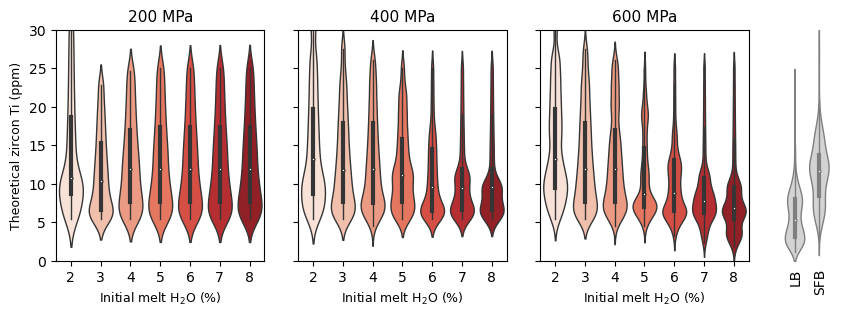

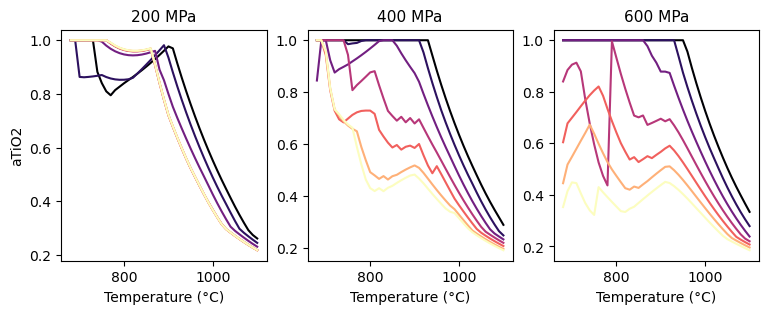

In [4]:
start_Zr = 100
start_Zr2 = 100
bulkD_Zr = 0

norm = mpl.colors.Normalize(vmin=water_contents.min(), vmax=water_contents.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.magma)
cmap.set_array([])

df = pd.DataFrame(columns = ['Ti-in-zircon', 'Water content'])

T_zrc_sat = []

fig, axs = plt.subplots(1,4, figsize = (10,3), width_ratios = [3,3,3,0.7], sharey = True)

fig2, axs2 = plt.subplots(1,3, figsize = (9,3))


cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.magma)
cmap.set_array([])
axs_number = 0
for comps_all,T_all,F_all,aTiO2_all,aSiO2_all, bulk_DZrs_all in zip(comps_all_P, T_all_P, F_all_P, aTiO2_all_P, aSiO2_all_P, bulk_DZrs_all_P):
    n = 0
    for i,j,k, aTiO2, aSiO2, bulkD_Zr in zip(comps_all, T_all, F_all, aTiO2_all, aSiO2_all, bulk_DZrs_all):
        i = pd.DataFrame.from_dict(i)
        aTiO2_BA = BA_rutile_solubility(i, j)
        aTiO2_BA = np.where(aTiO2_BA > 1, 1, aTiO2_BA) # Rutile saturated
        aTiO2_BA[np.isnan(aTiO2_BA)] = 1
        aTiO2_BA = np.where(aTiO2_BA < 0.1, 1.0, aTiO2_BA) # Remove zero values
        
        i = i.clip(lower=0)
        i = i.fillna(0)
        xH2O = calc_xH2O(i)
        totals = i['SiO2'] + i['TiO2'] + i['Al2O3'] +  i['Fe2O3'] +  i['FeO'] +  i['MnO'] + i['MgO'] +  i['CaO'] +  i['Na2O'] + i['K2O']
        for col in i.iloc[:,:-1]:
            i[col] = 100*(i[col]/totals)

        # Fit optical basicity curve to only above 800C
        m = np.polyfit(j[0:np.argmax(j == 850)], calc_opt_bas(pd.DataFrame.from_dict(i))[0:np.argmax(j == 850)], 2)
        corrected = np.poly1d(m)(j)
        i['opt bas'] = corrected
        i['xH2O'] = xH2O
        i['P'] = [p]*len(i)
        i['Zr sat'] = calc_zrsat(pd.Series(j), i['P'], i['xH2O'], i['opt bas'])
        bulkD_Zr = np.array(bulkD_Zr)

        i['Zr conc'] = start_Zr * (k/100)**(bulkD_Zr-1)
        i['Zr conc2'] = start_Zr2 * (k/100)**(bulkD_Zr-1)
        i['SiO2 (anhydrous)'] = i['SiO2']/( i['SiO2'] + i['TiO2'] + i['Al2O3'] +  i['Fe2O3'] +  i['FeO'] +  i['MnO'] + i['MgO'] +  i['CaO'] +  i['Na2O'] + 
           i['K2O']) *100

        Ti_zircon_BA = calc_Ti_crisp(j,p,aTiO2_BA,aSiO2)
    
        Ti_zircon_BA = np.where((k<100) & (Ti_zircon_BA>0.01), Ti_zircon_BA, 0)
         
        # Calculate the index of the MELTS output (the run step) where zircon saturates
        idx = np.argwhere(np.diff(np.sign(i['Zr conc'] - 10**i['Zr sat']))).flatten()[0]
        T_zrc_sat.append(j[idx])
        
        zr_star = []
        n2 = 0
        
        # Make a list of the excess Zr produced by each crystallisation state after zircon saturates
        for a in (i['Zr conc'] > 10**i['Zr sat']):
            if a == True:
                zr_star.append(((i['Zr sat'][n2-1]-i['Zr sat'][n2])))
            if a == False:
                zr_star.append(0)
            n2 = n2 + 1    
        
        # calculate the % of zircon crystallised for each Ti in zircon concentration
        frequency = np.round(zr_star[idx+1:]/np.sum(zr_star[idx+1:])*1000).astype(int)
        frequency = np.where(np.array(frequency)<=0, 0, np.array(frequency))
        repeat = np.repeat(Ti_zircon_BA[idx+1:], frequency) # Make repeats based on frequency
        water_content = [water_contents[n]]*len(repeat)
        Ti_zircon_dist = pd.concat([pd.Series(repeat), pd.Series(water_content)], axis = 1)
        Ti_zircon_dist.columns = ['Ti-in-zircon', 'Water content']
        df = pd.concat([df, Ti_zircon_dist], axis = 0)

        zr_star = []
        n2 = 0

        for a in (i['Zr conc2'] > 10**i['Zr sat']):
            if a == True:
                zr_star.append(((i['Zr sat'][n2-1]-i['Zr sat'][n2])))
            if a == False:
                zr_star.append(0)
            n2 = n2 + 1    


        fun = scipy.interpolate.interp1d(x=Ti_zircon_BA, y=zr_star/np.sum(zr_star), kind=1)
        ts = np.linspace(Ti_zircon_BA.max(),Ti_zircon_BA.min(),len(Ti_zircon_BA))
        y2 = fun(ts)
        
        axs2[axs_number].plot(j, aTiO2_BA, color = cmap.to_rgba(water_contents[n]))
        
   
        n = n+1
    df_fil = df.drop(df[df['Ti-in-zircon'] == 0 ].index)
    sb.violinplot(data = df_fil, y = 'Ti-in-zircon', x = 'Water content', scale = 'width',
                        palette = 'Reds', linewidth = 1.0, ax = axs[axs_number])
#     sb.boxplot(data = df_fil, y = 'Ti-in-zircon', x = 'Water content', palette = 'Reds', linewidth = 1.0, ax = axs[axs_number])
    
    axs_number = axs_number + 1

# Import Los Bronces data for comparison
lb_data = pd.read_csv('FAMOS_data_python.csv')
lb_data['Ti49_ppm'] = pd.to_numeric(lb_data['Ti49_ppm'], errors = 'coerce')
lb_data_porphyry = lb_data[lb_data['Label (JoyPlot)'] == 'Porphyry (economic)']
lb_data_bath = lb_data[(lb_data['Label (JoyPlot)'] == 'Batholith') | (['Label (JoyPlot)'] == 'Porphyry (uneconomic)')]
lb_data_porphyry = pd.concat([pd.Series(['Porphyry']*len(lb_data_porphyry['Ti49_ppm']), name = 'Type'), lb_data_porphyry['Ti49_ppm'].reset_index(drop = True)], axis = 1)
lb_data_bath = pd.concat([pd.Series(['Batholith']*len(lb_data_bath['Ti49_ppm']), name = 'Type'), lb_data_bath['Ti49_ppm'].reset_index(drop = True)], axis = 1)
lb_data_violin = pd.concat([lb_data_porphyry, lb_data_bath], axis = 0)
sb.violinplot(x = lb_data_violin['Type'], y = lb_data_violin['Ti49_ppm'], scale = 'width', linewidth = 1.0, ax = axs[3], color = 'lightgray')

axs[3].text(-0.25,-1,'LB', rotation = 90, verticalalignment = 'top')
axs[3].text(0.75,-1,'SFB', rotation = 90, verticalalignment = 'top')

axs[3].set_xlim([-0.5,1.5])
axs[3].axis('off')
    
axs[0].set_title('200 MPa', fontsize = 11)
axs[1].set_title('400 MPa', fontsize = 11)
axs[2].set_title('600 MPa', fontsize = 11)

axs[1].set_ylabel('')
axs[2].set_ylabel('')
axs[0].set_ylabel('Theoretical zircon Ti (ppm)', fontsize = 9)

for ax in axs[0:2]:
    ax.set_ylim([0,30])
    # ax.set_ylim([0,0.2])
    ax.set_xlabel('Initial melt H${_2}$O (%)', fontsize = 9)
 
axs[2].set_xlabel('Initial melt H${_2}$O (%)', fontsize = 9)

for ax in axs2:
    ax.set_xlabel('Temperature (°C)')
    
axs2[0].set_ylabel('aTiO2')

axs2[0].set_title('200 MPa', fontsize = 11)
axs2[1].set_title('400 MPa', fontsize = 11)
axs2[2].set_title('600 MPa', fontsize = 11)
    
plt.show()